In [1]:
import cv2

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.animation as animation

from data import data_1hour
from catalogs import theoretical_sky
from interactive import *
from util import indices, rescale_quantile
from flow import Flow

import skimage as ski

%matplotlib widget

%load_ext autoreload
%autoreload 2

/fastpool/zwhuang/.conda/envs/lwa/lib/python3.11/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/fastpool/zwhuang/.conda/envs/lwa/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [2]:
image, psf, imwcs = data_1hour(0)

In [3]:
sky = theoretical_sky(imwcs, psf, catalog="VLSSR")

/fastpool/zwhuang/.conda/envs/lwa/lib/python3.11/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/fastpool/zwhuang/.conda/envs/lwa/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/fastpool/zwhuang/.conda/envs/lwa/lib/python3.11/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/fastpool/zwhuang/.conda/envs/lwa/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [4]:
# mask out artifacts outside of horizon
mask = (jnp.linalg.norm(indices(4096, 4096).reshape((4096 * 4096, 2)) - 4096//2, axis=1) < 0.85 * 4096 / 2).reshape((4096, 4096))

image = image * mask
sky = sky * mask

In [5]:
# bring the source image and theoretical sky to roughly the same brightness levels
sky = ski.exposure.match_histograms(sky, image)

In [6]:
# rescale image to [0, 1], taking (roughly) only positive flux information
image = rescale_quantile(image, 0.50, 0.99)
sky = rescale_quantile(sky, 0.50, 0.99)

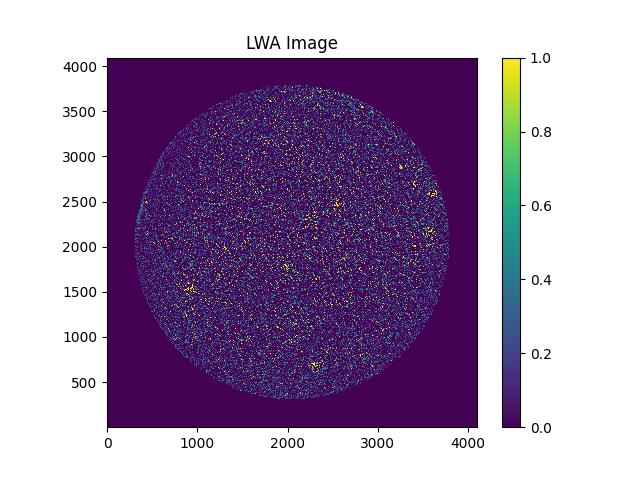

In [7]:
# press t to toggle between the two images
toggle_images(image, sky, vmax=1, title_1="LWA Image", title_2="Theoretical Sky")

In [8]:
flow = Flow.brox(image, sky, alpha=0.9, gamma=100, scale_factor=0.7)

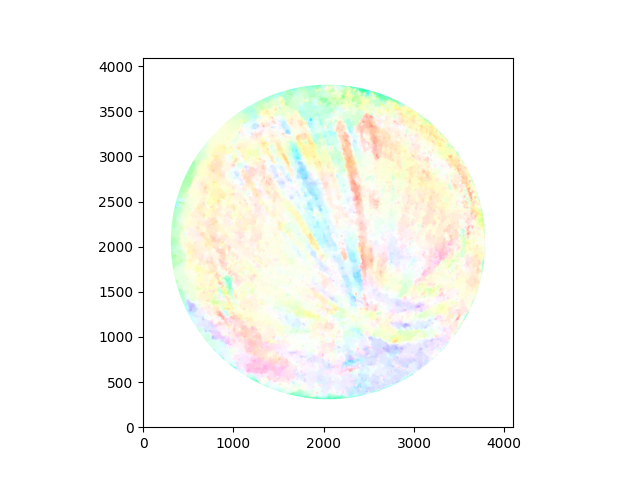

In [9]:
plt.close("rgb")
plt.figure("rgb")
plt.imshow(flow.to_rgb(mask), origin="lower")
plt.show()

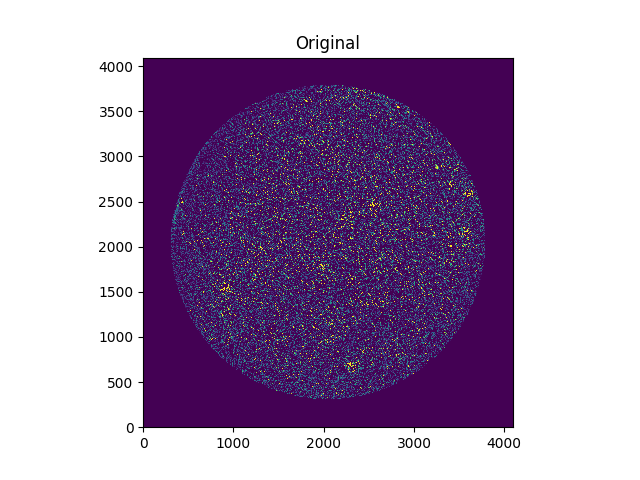

In [12]:
# press N and P to navigate to the next and previous images in the sequence, respectively.
sequence_images([image, flow.apply(image), sky], titles=["Original", "Dewarped", "Theoretical"])